# NonNegative ALS with just Stars

https://spark.apache.org/docs/latest/ml-collaborative-filtering.html

In [1]:
import pandas as pd
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [196]:
# import src_2.evaluate as evaluate

# # Convert a Pandas DF to a Spark DF
# spark_df = spark.createDataFrame(pandas_df) 

# # Convert a Spark DF to a Pandas DF
# pandas_df = spark_df.toPandas()

In [197]:
train_starred = pd.read_pickle('data/pickled/train_starred.pkl')
test_starred = pd.read_pickle('data/pickled/test_starred.pkl')

In [198]:
spark_train_stars_df = spark.createDataFrame(train_starred)
spark_test_stars_df = spark.createDataFrame(test_starred)

#### check spark dataframes

In [4]:
spark_train_stars_df.show()

+--------+-------+-------------------+---------------+----+--------------------+--------+-------+
| repo_id|user_id|         created_at|          login|type|                 url|language|starred|
+--------+-------+-------------------+---------------+----+--------------------+--------+-------+
|   12031| 889397|1202439272000000000|       cdcarter| USR|https://api.githu...|    Ruby|      1|
|52574448| 889397|1202442872000000000|       cdcarter| USR|https://api.githu...|      \N|      1|
|   12031|  17898|1203008090000000000|        gnufied| USR|https://api.githu...|    Ruby|      1|
|   12031|  25789|1203568157000000000|          Sutto| USR|https://api.githu...|    Ruby|      1|
|   12031|  10942|1203910346000000000|       tarcieri| USR|https://api.githu...|    Ruby|      1|
|   12031|  35126|1204050466000000000|         cypher| USR|https://api.githu...|    Ruby|      1|
|40916741| 401456|1204169012000000000|           dsrw| USR|https://api.githu...|   Shell|      1|
|   12031|  60568|12

In [5]:
spark_test_stars_df.show()

+--------+--------+-------------------+-----------------+----+--------------------+----------+-------+
| repo_id| user_id|         created_at|            login|type|                 url|  language|starred|
+--------+--------+-------------------+-----------------+----+--------------------+----------+-------+
|55567488| 6694284|1485492399000000000|          CaiJiJi| USR|https://api.githu...|    Python|      1|
|    1282|13665131|1485492672000000000|         tarvos21| USR|https://api.githu...|    Python|      1|
|   16356| 6806774|1485492818000000000|       acro5piano| USR|https://api.githu...|       PHP|      1|
|12651428|   11997|1485492868000000000|           alias1| USR|https://api.githu...|    Python|      1|
|  394885| 9279104|1485493232000000000|        nilsdeppe| USR|https://api.githu...|    Python|      1|
|29629404| 2060726|1485493578000000000|           Patola| USR|https://api.githu...|         C|      1|
|   38701|12092442|1485493937000000000|         buhuipao| USR|https://api

#### create ALS recommender model

In [199]:
als_model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='starred',
    implicitPrefs=True,
    nonnegative=True,    
    regParam=0.1,
    rank=10
    ) 

In [200]:
recommender = als_model.fit(spark_train_stars_df)
predictions = recommender.transform(spark_test_stars_df)

In [203]:
pred_df = predictions.toPandas()
pred_df.sort_values('prediction', ascending=False)

,repo_id,user_id,created_at,login,type,url,language,starred,prediction
138835,28557277,3011143,1496672996000000000,a5a,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,1.102072
137380,28557277,63262,1485843715000000000,jiessie,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.989328
162723,14098,13164165,1495363594000000000,nycatelos,USR,https://api.github.com/repos/radare/radare2,C,1,0.973631
120918,9664377,1733408,1497235274000000000,MaGuowei,USR,https://api.github.com/repos/tornadoweb/tornado,Python,1,0.970888
138107,28557277,4262703,1486886331000000000,jtlowery,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.957618
38342,424503,6075868,1489650656000000000,tzpBingo,USR,https://api.github.com/repos/soimort/you-get,Python,1,0.941444
11631,28686845,2531148,1492411569000000000,chinakook,USR,https://api.github.com/repos/aymericdamien/Ten...,Jupyter Notebook,1,0.923364
162705,14098,3362790,1490736627000000000,hslatman,USR,https://api.github.com/repos/radare/radare2,C,1,0.921127
138601,28557277,8681879,1488822736000000000,htadg,USR,https://api.github.com/repos/tensorflow/tensor...,C++,1,0.910691
128267,10170583,9255737,1487596797000000000,xeoneux,USR,https://api.github.com/repos/google/cadvisor,Go,1,0.907960


# NonNegative ALS with Stars & Forks (implicit weighted actions)

https://spark.apache.org/docs/latest/ml-collaborative-filtering.html

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [92]:
forks_and_stars = pd.read_pickle('data/pickled/forks_and_stars.pkl')
forks_and_stars.columns

Index([u'user_id', u'repo_id', u'forked', u'created_at', u'starred',
       u'interest_rank'],
      dtype='object')

#### since I didn't pickle train and test data for this run using both Star and Forks, create my timestamp ordered train-test split

In [93]:
def ordered_train_test_split(df, order_by, test_size=0.33):
    '''
    Takes a pandas dataframe and returns a train and test dataset ordered by the 
    column name passed to order_by and sliced up to the test_size
    INPUT:
    df: pandas df
    order_by: list or str of column names
    test_size: float percentage of df to use as test set
    OUTPUT:
    train: pandas dataframe
    test: pandas dataframe
    '''
    upto = int(df.shape[0] * (1 - test_size))
    df = df.sort_values(by=order_by, axis=0)
    train = df.iloc[:upto,:]
    test = df.iloc[upto:,:]
    return train, test

In [94]:
train_forks_stars, test_forks_stars = ordered_train_test_split(
    forks_and_stars, order_by=['created_at'], test_size=0.33)

In [95]:
print train_forks_stars.shape
print test_forks_stars.shape

(681076, 6)
(335456, 6)


#### create spark dataframes for train/test data

In [96]:
sp_train_forks_stars = spark.createDataFrame(train_forks_stars)
sp_test_forks_stars = spark.createDataFrame(test_forks_stars)

In [97]:
model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    implicitPrefs=True,
    nonnegative=True,    
    maxIter=10, 
    alpha=0.01
    ) 

In [98]:
recommender = model.fit(sp_train_forks_stars)
predictions = recommender.transform(sp_test_forks_stars)

In [99]:
pred_df = predictions.toPandas()

In [100]:
pred_df.sort_values(['user_id','prediction'], ascending=False)

,user_id,repo_id,forked,created_at,starred,interest_rank,prediction
17451,36791462,68425726,2.0,1498863052000000000,0.0,2.0,NaN
3042,36791293,20711751,2.0,1498861756000000000,1.0,3.0,NaN
93307,36791293,20711251,0.0,1498861751000000000,1.0,1.0,NaN
24524,36791076,38393576,2.0,1498860785000000000,0.0,2.0,NaN
141628,36790822,24958152,2.0,1498858442000000000,0.0,2.0,NaN
324068,36790741,63547354,2.0,1498860145000000000,0.0,2.0,NaN
320981,36790642,51568068,2.0,1498857388000000000,0.0,2.0,NaN
296748,36790336,13057459,2.0,1498855585000000000,0.0,2.0,NaN
255195,36789893,30334789,2.0,1498853132000000000,0.0,2.0,NaN
183068,36789460,27683242,2.0,1498850815000000000,0.0,2.0,NaN


# NonNegative ALS with Stars & Owned Repos (implicit weighted actions)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
# The following is only for working with RDDs
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
own_and_star = pd.read_pickle('data/pickled/new_subset_own_and_star.pkl')
own_and_star.columns
own_and_star.head(5)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank
0,2,4,0.0,4.0,2009-06-10 20:32:21,0.0,4.0
1,3,23,0.0,4.0,2011-02-19 02:58:42,0.0,4.0
2,5,28,6.0,4.0,2012-03-12 17:48:19,0.0,4.0
3,6,31,0.0,4.0,2010-11-18 23:17:00,0.0,4.0
4,10,67,0.0,4.0,2011-02-01 08:11:48,2.0,6.0


#### since I didn't pickle train and test data for this run using both Star and Forks, create my timestamp ordered train-test split

In [5]:
def ordered_train_test_split(df, order_by, test_size=0.33):
    '''
    Takes a pandas dataframe and returns a train and test dataset ordered by the 
    column name passed to order_by and sliced up to the test_size
    INPUT:
    df: pandas df
    order_by: list or str of column names
    test_size: float percentage of df to use as test set
    OUTPUT:
    train: pandas dataframe
    test: pandas dataframe
    '''
    upto = int(df.shape[0] * (1 - test_size))
    df = df.sort_values(by=order_by, axis=0)
    train = df.iloc[:upto,:]
    test = df.iloc[upto:,:]
    return train, test

In [6]:
train_owns_stars, test_owns_stars = ordered_train_test_split(
    own_and_star, order_by=['created_at'], test_size=0.33)

In [7]:
print train_owns_stars.shape
print test_owns_stars.shape

(2372137, 7)
(1168367, 7)


#### create spark dataframes for train/test data

In [8]:
sp_train_owns_stars = spark.createDataFrame(train_owns_stars)
sp_test_owns_stars = spark.createDataFrame(test_owns_stars)


In [9]:
sp_entire_dataset = spark.createDataFrame(own_and_star)

In [14]:
model = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,    
    regParam=1.0,
    rank=25,
    maxIter=15,
    alpha=10
    ) 

In [15]:
# Fit recommender model
recommenderall = model.fit(sp_entire_dataset)
recommender = model.fit(sp_train_owns_stars)

In [24]:
recommender.save("/home/ubuntu/PROJECT/github-collaborator/data/models/ALSmodel")

In [27]:
recommender = ALSModel.load("/home/ubuntu/PROJECT/github-collaborator/data/models/ALSmodel")

In [28]:
#Make some predicitons from test set
rawPredictions = recommender.transform(sp_test_owns_stars)

In [29]:
pred_df = rawPredictions.toPandas()

In [31]:
pred_df.sort_values('prediction', ascending=False).head()

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
1005690,10901621,1090484,0.0,0.0,1470778280000000000,2.0,2.0,5.270817
18743,35591075,1090484,0.0,0.0,1470777948000000000,2.0,2.0,5.253704
1113354,29215456,1090484,0.0,0.0,1470777972000000000,2.0,2.0,4.967988
673441,35535175,1789129,0.0,0.0,1484395063000000000,2.0,2.0,4.780213
673473,35535175,11007330,0.0,0.0,1481011878000000000,2.0,2.0,4.684288


### random

In [220]:
null_predictions = sum(pred_df['prediction'].isnull())


In [310]:
pred_df.sort_values(['prediction'], ascending=False).iloc[10000:10100,:]

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
365020,18521760,249979,0,0.0,1493129173000000000,1.0,1.0,0.229794
327702,13407509,154877,0,0.0,1496342869000000000,1.0,1.0,0.229787
108722,31810056,497349,0,0.0,1497853711000000000,1.0,1.0,0.229773
249095,43786,5723,0,0.0,1490296951000000000,1.0,1.0,0.229768
95065,10495335,216188,0,0.0,1483220551000000000,1.0,1.0,0.229762
40976,5219,11670696,0,0.0,1487564281000000000,1.0,1.0,0.229748
287290,19911836,67696,0,0.0,1489368728000000000,1.0,1.0,0.229747
204809,12831,3944360,0,0.0,1485890558000000000,1.0,1.0,0.229737
327658,13407509,1484460,0,0.0,1497385450000000000,1.0,1.0,0.229736
23239,28686845,156029,0,0.0,1487498621000000000,1.0,1.0,0.229733


In [227]:
non_null = pred_df.loc[pred_df['prediction'].isnull() == False]
non_null = non_null['prediction']


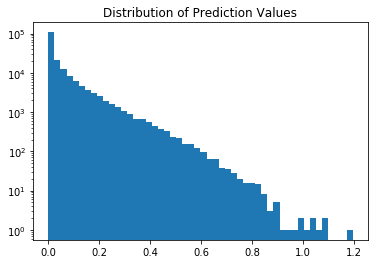

In [229]:
plt.hist(non_null, bins=50)
plt.title("Distribution of Prediction Values")
plt.yscale('log');

In [230]:
# Predictions where repo-user has just a OWNS relationship
(pred_df.loc[(pred_df.interest_rank == 4) & (~pred_df.prediction.isnull())]).sort_values(
    'prediction', ascending=False)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
245113,52878664,2216159,0,4.0,1481755233000000000,0.0,4.0,0.016881
123447,53531959,599582,0,4.0,1482796812000000000,0.0,4.0,0.001790
28325,56322797,10433,0,4.0,1486246603000000000,0.0,4.0,0.001627
182690,56341200,2606940,0,4.0,1486310145000000000,0.0,4.0,0.000544
285944,53389749,9652,0,4.0,1482540899000000000,0.0,4.0,0.000397
21771,56725833,10269343,0,4.0,1486185254000000000,0.0,4.0,0.000061
75564,52688610,596995,0,4.0,1481277537000000000,0.0,4.0,0.000050
64988,52668800,265517,0,4.0,1481575228000000000,0.0,4.0,0.000041
114402,56507651,7830654,0,4.0,1486218712000000000,0.0,4.0,0.000008
31448,56531417,693322,0,4.0,1486351589000000000,0.0,4.0,0.000000


In [131]:
(pred_df.loc[pred_df.user_id == 9652]).sort_values('prediction', ascending=False)

,repo_id,user_id,forked_from_repo_id,owned,created_at,starred,interest_rank,prediction
285944,53389749,9652,0,4.0,1482540899000000000,0.0,4.0,0.844856


In [231]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366344 entries, 0 to 366343
Data columns (total 8 columns):
repo_id                366344 non-null int64
user_id                366344 non-null int64
forked_from_repo_id    366344 non-null int64
owned                  366344 non-null float64
created_at             366344 non-null int64
starred                366344 non-null float64
interest_rank          366344 non-null float64
prediction             181703 non-null float64
dtypes: float64(4), int64(4)
memory usage: 22.4 MB


#### RMSE won't really work for implicit data since there are no target values you're trying to hit, just a strength the model believes the user would have an interest in the repo

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator

In [36]:
rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))

In [37]:
predictions = rawPredictions\
    .withColumn("interest_rank", rawPredictions.interest_rank.cast("double"))\
    .withColumn("prediction", rawPredictions.prediction.cast("double"))
evaluator =\
    RegressionEvaluator(metricName="rmse", labelCol="interest_rank", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.739859499114


#### See what predictions come from all users-repos

The 'prediction' Spark ALS returns for user-repo combos (using implicit ratings) is the level of confidence the model has that the user would interact the repo.

So to make repo recommendations for a user, I need to run .transform() on a spark dataframe of that user against every repo I have.

## Crete little dataframe of random user-repo mappings to use for predictions for recommendations

In [77]:
repos = pd.read_pickle('data/pickled/new_subset_repos.pkl')
users = pd.read_pickle('data/pickled/new_subset_users.pkl')

In [78]:
def random_user_against_repos(users_df, repos_df):
    user = users_df['id'].iloc[np.random.choice(users_df.shape[0])]
    prediction_df = pd.DataFrame(repos_df['id'])
    prediction_df['user_id'] = user
    prediction_df = prediction_df.rename(columns={'id':'repo_id'})
    return prediction_df

In [79]:
df = random_user_against_repos(users, repos)
df.head(3)

,repo_id,user_id
0,2,2517863
1,3,2517863
2,5,2517863


In [42]:
df['user_id'] = 7271611

### Make predictions and order by top recommendations

In [80]:
test_user = spark.createDataFrame(df)
predictions_user = recommenderall.transform(test_user)
predictions_user.toPandas().sort_values('prediction', ascending=False).head(10)

,repo_id,user_id,prediction
93936,49060702,2517863,6.738385
187945,32144805,2517863,6.467147
1048752,13745548,2517863,6.444273
650636,10908073,2517863,6.444273
797744,1098428,2517863,6.444273
823944,21509204,2517863,6.423631
320297,47416195,2517863,6.423631
504512,43189759,2517863,6.380615
1100746,3293712,2517863,6.366199
570326,51926377,2517863,6.335629


In [45]:
repos[repos.id == 1530831]

,id,url,owner_id,name,language,created_at,forked_from
92625,1530831,https://api.github.com/repos/mon-key/magit,6077,magit,Emacs Lisp,2011-09-13 03:40:40,26454


In [44]:
users[users.id == 7271611]

,id,login,company,created_at,type,country_code,state,city,location
50004,7271611,ayadlin,\N,2015-03-03 19:39:51,USR,\N,\N,\N,\N


## Define a metric for evaluating recommender

In [2]:
def mean_percentage_ranking(model, test_df):
    '''
    Metric for evaluating recommender model quality.
    For the starred and owned repos for a user in the test set,
    how far down the top recommended repos does it take to capture them.
    
    Something like 
    1. group test_df by user_id to get a list of repo_ids they actually interacted with
    2. sort the predictions_df by top recommendations for a user
    3. count how far down the predictions_df until all the test_df repo_ids for a user occur
    4. divide the num of test_df repo_ids by the count down to find all repo_ids, and append that
        ratio to a list
    5. Take the mean of the list of ratios
    '''
    test_df = spark.toPandas()
    user_set = set(test_df.user_id)
    repo_set = set(test_df.repo_id)
    
    for user in user_set:
        # Make predictions for user against all test repos
        user_df = pd.DataFrame(test_df.repo_id)
        user_df['user_id'] = user
        predictions = model.transform(user_df)
        # Sort predictions so recommendations are top
        predictions = spark.toPandas(predictions)
        predictions = predictions.sort_values('prediction', ascending=False)
        print predictions.head(3)
    

In [ ]:
mean_percentage_ranking(recommender, sp_test_owns_stars)

In [34]:
from evaluator.validate import *

saving calculated NDCGs to  /run/user/1000/jupyter/kernel-879d2760-f372-43ee-8744-1194a97a5741.json


IOError: [Errno 2] No such file or directory: '-f'

## Use SVD matrix factorization in Surprise library

In [109]:
from surprise.dataset import Reader
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf

In [112]:
own_and_star = pd.read_pickle('data/pickled/new_subset_own_and_star.pkl')

In [113]:
own_and_star = own_and_star[['user_id','repo_id','interest_rank','created_at']]
own_and_star.to_csv('data/new_subset_data/own_and_star.csv', index=False)

In [114]:
ownstar = pd.read_csv('data/new_subset_data/own_and_star.csv')
ownstar.info()
ownstar.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540504 entries, 0 to 3540503
Data columns (total 4 columns):
user_id          int64
repo_id          int64
interest_rank    float64
created_at       object
dtypes: float64(1), int64(2), object(1)
memory usage: 108.0+ MB


Index([u'user_id', u'repo_id', u'interest_rank', u'created_at'], dtype='object')

In [120]:
# path to dataset file
file_path = os.path.expanduser('data/new_subset_data/own_and_star.csv')

# As we're loading a custom dataset, we need to define a reader. In the
# movielens-100k dataset, each line has the following format:
# 'user item rating timestamp', separated by '\t' characters.
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(2,6))

data = Dataset.load_from_file(file_path, reader=reader)
data.split(n_folds=3)

In [119]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8011
MAE:  0.5721
------------
Fold 2
RMSE: 0.8014
MAE:  0.5728
------------
Fold 3
RMSE: 0.7999
MAE:  0.5716
------------
Fold 4
RMSE: 0.8015
MAE:  0.5728
------------
Fold 5
RMSE: 0.8011
MAE:  0.5728
------------
------------
Mean RMSE: 0.8010
Mean MAE : 0.5724
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.5721  0.5728  0.5716  0.5728  0.5728  0.5724  
RMSE    0.8011  0.8014  0.7999  0.8015  0.8011  0.8010  


### this did not work since dataset is too large. Took all night and wa still running in morning

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# # First train an SVD algorithm on my repo dataset
# data = Dataset.load_from_file(file_path, reader=reader)
# data.split(n_folds=3)

trainset = data.build_full_trainset()
algo = SVD()
algo.train(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

## GridSearch in Spark

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [12]:
als = ALS(
    itemCol='repo_id',
    userCol='user_id',
    ratingCol='interest_rank',
    nonnegative=True,
    maxIter=10)

# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \ 
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, [10, 15, 20, 25, 30, 35]) \
    .addGrid(als.alpha, [0.1, 1.0, 5, 10, 20, 40]) \
    .build()

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse", 
                                                        labelCol="interest_rank", 
                                                        predictionCol="prediction"),
                          numFolds=3)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(sp_train_owns_stars)

SyntaxError: unexpected character after line continuation character (<ipython-input-12-f1416e2d9324>, line 12)